Forecasting Condition Using Contextually Enriched SCANNER data
===

This notebooke presents an end-to-end modelling workflow for condition forecasting. The presented version is Rutting, but the model is identical (except training!) for texture depth and roughness models. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import seaborn as sns

import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
import shap

from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis

db_connection_string = "postgresql://<database>:<user>@service:5432/<database>" # cleaned to remove personally identifying usernames etc.
engine = create_engine(db_connection_string)


Build the enriched feature set from the database
===
This large query retrieves all the component parts from the database. In the final implementation, the resulting table is saved as "process_road_scanner.characterised_clusters".

Included here for transparency. 


In [ ]:

# This large query retrieves all the component parts from the database. 
# In the final implementation, the resulting table is saved as "process_road_scanner.characterised_clusters", but 
# inclusion of the query here gives transparency. 

query = """

-- Starting with travel along the carriageway (distance to junction). Build the list of section lengths. 
with section_lengths_g as (
select 
max(start_chainage) section_length,
section_ref
from process_road_scanner.clustered_points
group by section_ref
),

-- Need a unique ID, and we can't use row_number in a group.
section_lengths as (
select
row_number() over () section_uid,
* from section_lengths_g ),

-- calculate the distance along the junction, varying by lane (CL/CR). 
-- Expressed as a percentage, which solves normalisation
distances as (
select 
a.cluster_id_2 cluster_id, 
a.section_ref,
a.lane_ref,
a.start_chainage,
b.section_uid,
b.section_length,
case 
 when lane_ref = 'CL1' then (section_length - start_chainage)--/section_length
 when lane_ref  = 'CR1' then start_chainage--/section_length
end distance_to_junction
from 
process_road_scanner.clustered_points a,
section_lengths b
where a.section_ref = b.section_ref ),

-- for the mode value calculations. 
frequency_counts AS (
  SELECT 
    section_uid,
    cluster_id, 
    distance_to_junction,
    COUNT(*) AS frequency
  FROM distances
  GROUP BY cluster_id, distance_to_junction, section_uid
),

-- for the mode value calculation. again, need the group-by to use rank()
ranked_distances AS (
  SELECT 
    section_uid,
    cluster_id,
    distance_to_junction,
    frequency,
    RANK() OVER (PARTITION BY cluster_id ORDER BY frequency DESC) AS rank
  FROM frequency_counts
),

-- for the mode value calculation. Actually calculating the mode!
reported_distances as(
SELECT 
  section_uid,
  cluster_id,
  distance_to_junction AS mode_distance_to_junction
FROM ranked_distances
WHERE rank = 1 ),

-- adding our distance calulation to the all-parameters centers and descriptives table. 
centers_and_descriptives as (
select a.*, 
b.mode_distance_to_junction,
b.section_uid
from 
condition.cluster_centers_all_params_2 a, 
reported_distances b
where a.cluster_id = b.cluster_id),


-- these queries allow grouping based on reported chainage, rather than actual clusters.
unique_refs as (
select 
ST_X(ST_Transform(geom, 27700)) AS easting,
ST_Y(ST_Transform(geom, 27700)) AS northing,
*,
(section_ref || lane_ref || start_chainage) uid
from process_road_scanner.maintenance_clusters ),

reference_ids as (
select 
row_number() over () reference_id,
uid,
count(*)
from unique_refs
group by uid), 

scanner_clusters as (
select a.*, 
b.reference_id from 
unique_refs a, 
reference_ids b
where a.uid = b.uid)


-- build the raw feature table. table 'a' is the clusters, table 'b' is our centers and descriptives CTE table.
select 
a.section_ref,
a.easting,
a.northing,
a.survey_date,
a.lane_ref,
a.reference_id cluster_id, 
a.llrd,
a.lv10,
a.ltrc,
a.lltx,
a.start_chainage,
1/a.lcrv lcrv, -- inverse radius of turn.
a.lfal,
a.lgrd,
b.section_uid,
b.aadt_2018 aadt,
b.hgv_aadf,
b.speed_limit,
b.mode_distance_to_junction,
b.geomorphons_1 as geotech,
b.combined_geolcode,
b.drainage_mean,
b.drainage_median,
b.drainage_max

from 
scanner_clusters a
left join 
centers_and_descriptives b
on a.cluster_id_2 = b.cluster_id
where cluster_id_2 is not null -- needs to be removed for described centers, because otherwhise we double dip.
"""
# Load into DataFrame
df = pd.read_sql(query, engine, parse_dates=["survey_date"])

min_date = df['survey_date'].min()

# Numeric feature for modeling
df['survey_days'] = (df['survey_date'] - min_date).dt.days

Normalisation of Target variables and features
---

In [ ]:

df['llrd_log'] = np.log1p(df['llrd'])   # log1p(x) = log(x + 1). 
df['lv10_log'] = np.log1p(df['lv10'])
df['lltx_log'] = np.log1p(df['lltx'])

def clip_outliers_iqr(series, factor=1.5):
    # removing at 15th and 85th percentile.
    q1 = series.quantile(0.05)
    q3 = series.quantile(0.95)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

# Apply to log-transformed columns
df['llrd_log_clipped'] = clip_outliers_iqr(df['llrd_log'])
df['lv10_log_clipped'] = clip_outliers_iqr(df['lv10_log'])
df['lltx_log_clipped'] = clip_outliers_iqr(df['lltx_log'])

# non condition feature characteristics.

# clip outliers
df['lfal_clipped'] = clip_outliers_iqr(df['lfal'])
df['lcrv_clipped'] = clip_outliers_iqr(df['lcrv'])

# Standardize the features
scaler = StandardScaler()
columns_to_standardize = ['lfal_clipped', 'lcrv_clipped']# 'mode_distance_to_junction'] #, 'aadt', 'hgv_aadf']
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df['sqrt_mdj'] = np.sqrt(df['mode_distance_to_junction'])


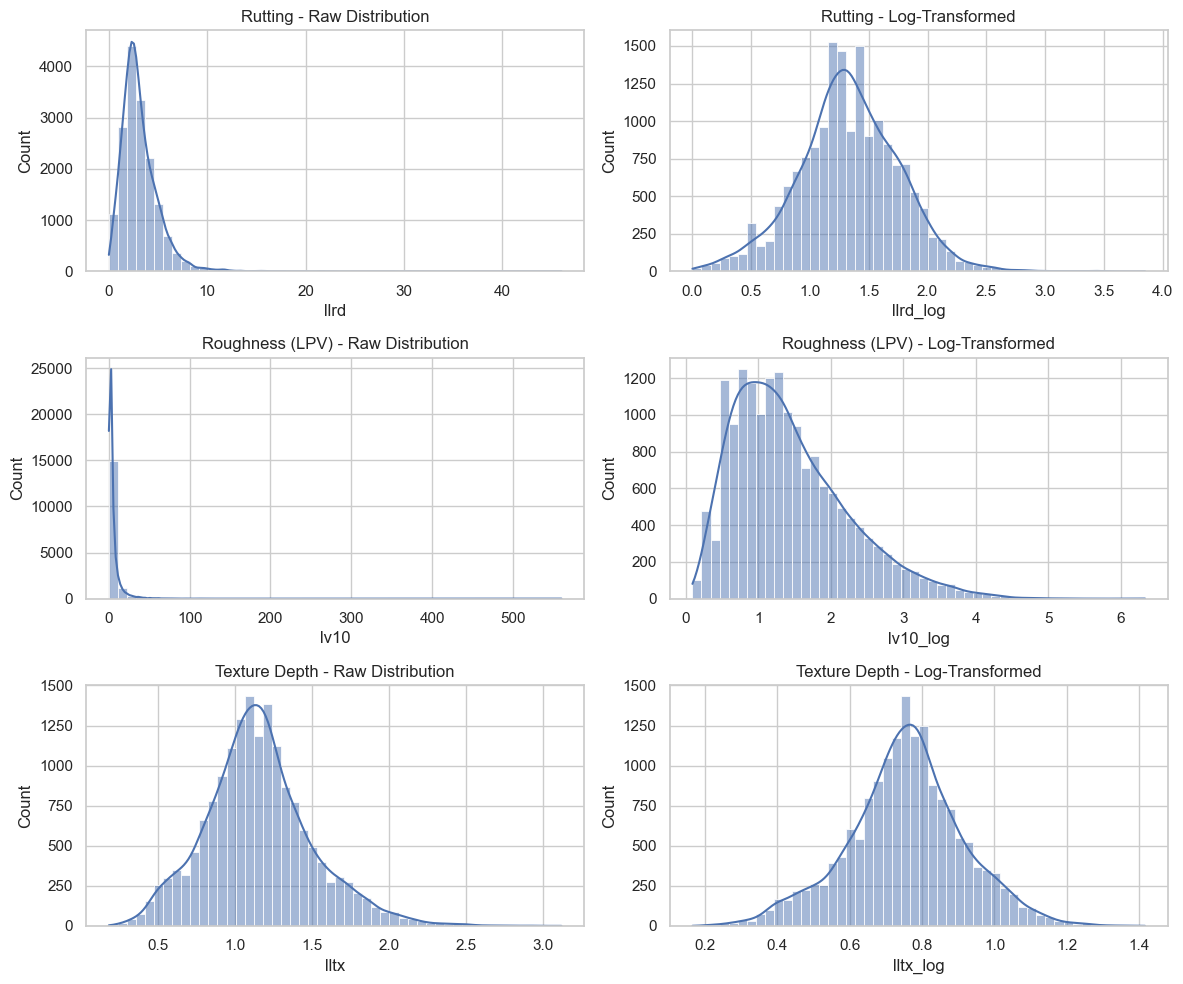

In [ ]:
# Dictionary mapping variable names to thier full descriptions
metric_names = {
    'llrd': 'Rutting',
    'lv10': 'Roughness (LPV)',
    'lltx': 'Texture Depth'
}

metrics = ['llrd', 'lv10', 'lltx']

fig, axs = plt.subplots(len(metrics), 2, figsize=(12, 10))

for i, col in enumerate(metrics):
    sns.histplot(df[col], bins=50, ax=axs[i, 0], kde=True)
    axs[i, 0].set_title(f"{metric_names[col]} - Raw Distribution")

    # Log transform (avoid log(0))
    df[f"{col}_log"] = np.log1p(df[col])
    sns.histplot(df[f"{col}_log"], bins=50, ax=axs[i, 1], kde=True)
    axs[i, 1].set_title(f"{metric_names[col]} - Log-Transformed")

plt.tight_layout()
plt.show()

Creating lag features for use in the regression model.
---

In [ ]:

# lag 1
df_sorted = df.sort_values(by=["cluster_id", "survey_date"])
df_sorted["llrd_log_lag1"] = df_sorted.groupby("cluster_id")["llrd_log_clipped"].shift(1)
df_sorted["lv10_log_lag1"] = df_sorted.groupby("cluster_id")["lv10_log_clipped"].shift(1)
df_sorted["lltx_log_lag1"] = df_sorted.groupby("cluster_id")["lltx_log_clipped"].shift(1)
df_sorted["survey_days_lag1"] = df_sorted.groupby("cluster_id")["survey_days"].shift(1)
df_sorted["delta_days"] = df_sorted["survey_days"] - df_sorted["survey_days_lag1"]

# remember, survey days is the number of between the first survey in the dataset, and this survey.
# that means that delta days is stepping back from that value. i.e., 

# 1st survey event in dataset --------------------------------------->survey_days
#                                                   delta days<------>
#                              delta_days_lag<----->

# lag 2 'lag of lag'
df_sorted["llrd_log_lag2"] = df_sorted.groupby("cluster_id")["llrd_log_lag1"].shift(1)
df_sorted["lv10_log_lag2"] = df_sorted.groupby("cluster_id")["lv10_log_lag1"].shift(1)
df_sorted["lltx_log_lag2"] = df_sorted.groupby("cluster_id")["lltx_log_lag1"].shift(1)
df_sorted["survey_days_lag2"] = df_sorted.groupby("cluster_id")["survey_days_lag1"].shift(1)
df_sorted["delta_days_lag"] = df_sorted["survey_days_lag1"] - df_sorted["survey_days_lag2"]

In [ ]:
df_sorted.describe()

,easting,northing,survey_date,cluster_id,llrd,lv10,ltrc,lltx,start_chainage,lcrv,...,llrd_log_lag1,lv10_log_lag1,lltx_log_lag1,survey_days_lag1,delta_days,llrd_log_lag2,lv10_log_lag2,lltx_log_lag2,survey_days_lag2,delta_days_lag
count,16751.000000,16751.000000,16751,16751.000000,16751.000000,16746.000000,16751.000000,16751.000000,16751.000000,16751.000000,...,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,7715.000000,7715.000000,7715.000000,7715.000000,7715.000000
mean,465364.743619,348011.917457,2016-10-18 06:27:57.607307008,3009.393708,3.144714,5.311238,0.246552,1.153430,723.681512,0.000048,...,1.332688,1.422850,0.754990,3310.686304,620.446291,1.364700,1.395729,0.758266,2988.901491,597.279326
min,462336.550000,341592.850000,2007-02-11 00:00:00,1.000000,0.000000,0.100000,0.000000,0.180000,0.000000,-0.051948,...,0.000000,0.095310,0.198851,0.000000,0.000000,0.000000,0.095310,0.207014,0.000000,0.000000
25%,462525.275000,344745.475000,2014-10-22 00:00:00,1525.000000,1.900000,1.300000,0.000000,0.940000,290.000000,-0.000500,...,1.064711,0.832909,0.662688,2421.000000,686.000000,1.098612,0.832909,0.672944,2421.000000,389.000000
50%,465066.950000,347917.200000,2016-09-07 00:00:00,2998.000000,2.800000,2.600000,0.000000,1.130000,609.000000,0.000500,...,1.335001,1.280934,0.756122,3129.000000,708.000000,1.360977,1.252763,0.760806,2810.000000,708.000000
75%,467618.650000,351066.840750,2019-08-01 00:00:00,4509.000000,4.000000,5.600000,0.000000,1.340000,1092.000000,0.000500,...,1.609438,1.871802,0.850151,4213.000000,732.000000,1.648659,1.824549,0.850151,3496.000000,717.000000
max,469939.800000,355050.400000,2021-08-15 00:00:00,6007.000000,46.000000,560.030000,9.600000,3.120000,2090.000000,0.033003,...,3.471966,5.352332,1.415853,5299.000000,2534.000000,3.471966,5.065755,1.415853,4955.000000,2534.000000
std,2537.682264,3801.811918,NaN,1725.986596,1.985267,9.638679,0.704922,0.348463,519.494354,0.003179,...,0.421918,0.783120,0.161744,849.311208,268.359708,0.403428,0.779021,0.158184,698.158322,295.188946


Select only used features from the large characterised_cluster dataset
--

In [ ]:

target_raw = "llrd"
target = target_raw+"_log_clipped"

# remove the variables used for other defect types using comments. Allows for one notebook to serve multipl files with minimal config change.  
features = [
    "cluster_id", # Removed before training. Used to prevent leakage of clusters between test, train, and valdiate. 
    "aadf",
    "hgv_aadf",
    "lcrv_clipped",
    "lfal_clipped",
    "lgrd",
    "speed_limit",
    "number_of_lanes",
    "sqrt_mdj",
    "geotech",
    "llrd_log_lag1", 
 #  "lv10_log_lag1", 
 #  "lltx_log_lag1", 
    "delta_days",
    "llrd_log_lag2", 
 #  "lv10_log_lag2", 
 #  "lltx_log_lag2", 
    "delta_days_lag"
]


# Drop any rows with N/A (e.g., first lag in each cluster)
df_model = df_sorted.dropna(subset=features + [target]).copy()

df_model.describe()

,easting,northing,survey_date,cluster_id,llrd,lv10,ltrc,lltx,start_chainage,lcrv,...,llrd_log_lag1,lv10_log_lag1,lltx_log_lag1,survey_days_lag1,delta_days,llrd_log_lag2,lv10_log_lag2,lltx_log_lag2,survey_days_lag2,delta_days_lag
count,7653.000000,7653.000000,7653,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,...,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000,7653.000000
mean,465180.988087,348354.604545,2018-09-08 02:00:14.112112896,3004.696459,3.101999,5.074192,0.319038,1.197668,680.530511,0.000178,...,1.309957,1.382913,0.763772,3587.612701,639.470796,1.364209,1.386459,0.758389,2990.598589,597.014112
min,462350.100000,341627.850000,2007-02-11 00:00:00,1.000000,0.000000,0.100000,0.000000,0.180000,0.000000,-0.040683,...,0.000000,0.095310,0.198851,0.000000,0.000000,0.000000,0.095310,0.207014,0.000000,0.000000
25%,462470.550000,345261.750000,2016-09-07 00:00:00,1520.000000,1.900000,1.220000,0.000000,0.960000,280.000000,-0.000500,...,1.029619,0.788457,0.667829,3129.000000,686.000000,1.098612,0.788457,0.672944,2421.000000,389.000000
50%,464514.200000,348171.200000,2018-08-25 00:00:00,2999.000000,2.700000,2.500000,0.000000,1.170000,560.000000,0.000500,...,1.308333,1.223775,0.765468,3496.000000,717.000000,1.360977,1.223775,0.760806,2810.000000,708.000000
75%,467480.250000,351802.850000,2020-09-05 00:00:00,4508.000000,3.900000,5.200000,0.200000,1.400000,1010.000000,0.000500,...,1.609438,1.808289,0.858662,4213.000000,732.000000,1.648659,1.808289,0.850151,3496.000000,717.000000
max,469924.250000,355009.500000,2021-08-15 00:00:00,6005.000000,19.100000,210.100000,9.600000,3.030000,2090.000000,0.027902,...,3.000720,5.352332,1.415853,5299.000000,2534.000000,3.471966,5.065755,1.415853,4955.000000,2534.000000
std,2557.277383,3869.268197,NaN,1728.997583,1.853217,8.646726,0.820332,0.365463,491.567217,0.002114,...,0.436013,0.768391,0.161549,696.488480,221.679143,0.404299,0.770320,0.157999,697.486170,294.372179


Split for test, train, and validate
---

use the clusterid to inform test, train and validate to prevent leakage between sets. 

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

def train_val_test_split(df, group_col, test_size=0.15, val_size=0.15, random_state=42):
    """Split df into train, val, test sets grouped by group_col."""

    # First split off test
    gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(gss1.split(df, groups=df[group_col]))
    
    df_train_val = df.iloc[train_val_idx].copy()
    df_test = df.iloc[test_idx].copy()
    
    # Now split train_val into train and val
    val_relative_size = val_size / (1 - test_size)  # Adjust val size relative to remaining data
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_relative_size, random_state=random_state)
    train_idx, val_idx = next(gss2.split(df_train_val, groups=df_train_val[group_col]))
    
    df_train = df_train_val.iloc[train_idx].copy()
    df_val = df_train_val.iloc[val_idx].copy()
    
    return df_train, df_val, df_test


df_train, df_val, df_test = train_val_test_split(df_model, "cluster_id")
df_train.describe()

,easting,northing,survey_date,cluster_id,llrd,lv10,ltrc,lltx,start_chainage,lcrv,...,llrd_log_lag1,lv10_log_lag1,lltx_log_lag1,survey_days_lag1,delta_days,llrd_log_lag2,lv10_log_lag2,lltx_log_lag2,survey_days_lag2,delta_days_lag
count,5417.000000,5417.000000,5417,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,...,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000
mean,465238.168488,348280.423755,2018-09-01 13:56:02.082333184,3055.988555,3.097028,4.948852,0.329943,1.194550,677.134207,0.000204,...,1.310835,1.383147,0.762183,3588.907144,631.673435,1.365783,1.387645,0.756217,2998.223925,590.683219
min,462350.100000,341627.850000,2007-02-11 00:00:00,2.000000,0.000000,0.100000,0.000000,0.180000,0.000000,-0.038300,...,0.000000,0.095310,0.198851,0.000000,0.000000,0.000000,0.095310,0.207014,0.000000,0.000000
25%,462471.150000,345034.550000,2016-09-07 00:00:00,1598.000000,1.900000,1.240000,0.000000,0.960000,280.000000,-0.000500,...,1.029619,0.788457,0.667829,3129.000000,686.000000,1.131402,0.832909,0.672944,2421.000000,389.000000
50%,464590.200000,348086.300000,2018-08-25 00:00:00,3054.000000,2.700000,2.520000,0.000000,1.170000,560.000000,0.000500,...,1.308333,1.252763,0.765468,3496.000000,717.000000,1.335001,1.252763,0.760806,2810.000000,708.000000
75%,467560.500000,351773.550000,2020-09-05 00:00:00,4574.000000,3.900000,5.280000,0.200000,1.400000,990.000000,0.000500,...,1.589235,1.808289,0.858662,4213.000000,732.000000,1.648659,1.824549,0.845868,3496.000000,717.000000
max,469924.250000,355009.500000,2021-08-15 00:00:00,6003.000000,19.100000,210.100000,9.600000,2.920000,2080.000000,0.027902,...,3.000720,5.352332,1.415853,5299.000000,2534.000000,3.471966,4.790820,1.415853,4955.000000,2534.000000
std,2580.645342,3917.902285,NaN,1729.716741,1.862810,8.213848,0.842098,0.365679,489.256794,0.002114,...,0.433062,0.753333,0.162388,701.913452,231.836711,0.403908,0.756843,0.159066,699.753693,297.843434


In [ ]:
df_test.describe()

,easting,northing,survey_date,cluster_id,llrd,lv10,ltrc,lltx,start_chainage,lcrv,...,llrd_log_lag1,lv10_log_lag1,lltx_log_lag1,survey_days_lag1,delta_days,llrd_log_lag2,lv10_log_lag2,lltx_log_lag2,survey_days_lag2,delta_days_lag
count,1144.000000,1144.000000,1144,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,...,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,465047.677360,348552.721809,2018-10-04 14:37:20.559440640,2855.727273,3.029108,4.945446,0.287500,1.191346,672.833916,0.000109,...,1.285142,1.333227,0.758235,3590.752622,662.856643,1.348159,1.335991,0.755013,2971.153846,619.598776
min,462350.850000,341635.900000,2013-09-28 00:00:00,1.000000,0.000000,0.200000,0.000000,0.240000,2.000000,-0.037994,...,0.000000,0.182322,0.215111,2421.000000,0.000000,0.095310,0.182322,0.215111,0.000000,0.000000
25%,462468.800000,345794.075000,2016-09-07 00:00:00,1260.000000,1.800000,1.200000,0.000000,0.950000,280.000000,-0.000500,...,0.993252,0.788457,0.661396,3129.000000,686.000000,1.098612,0.788457,0.667829,2421.000000,389.000000
50%,464531.800000,348145.950000,2018-08-25 00:00:00,2839.000000,2.700000,2.125000,0.000000,1.180000,570.000000,-0.000500,...,1.308333,1.131402,0.760806,3496.000000,717.000000,1.335001,1.131402,0.756122,2810.000000,708.000000
75%,467244.962500,351902.387500,2020-09-05 00:00:00,4322.250000,3.900000,4.600000,0.100000,1.380000,1050.000000,0.000500,...,1.589235,1.722767,0.851217,4213.000000,732.000000,1.634095,1.727191,0.841567,3496.000000,717.000000
max,469919.050000,355003.500000,2021-08-15 00:00:00,6005.000000,15.200000,85.820000,8.300000,2.540000,2060.000000,0.024802,...,2.785011,4.352855,1.264127,4955.000000,1075.000000,2.785011,4.244200,1.278152,4955.000000,2421.000000
std,2485.416066,3734.233702,NaN,1772.257328,1.774432,8.664139,0.745081,0.358835,477.255009,0.002152,...,0.440370,0.783658,0.157987,676.793992,186.836767,0.405449,0.777237,0.153948,686.705585,283.455528


In [ ]:
df_val.describe()

,easting,northing,survey_date,cluster_id,llrd,lv10,ltrc,lltx,start_chainage,lcrv,...,llrd_log_lag1,lv10_log_lag1,lltx_log_lag1,survey_days_lag1,delta_days,llrd_log_lag2,lv10_log_lag2,lltx_log_lag2,survey_days_lag2,delta_days_lag
count,1092.000000,1092.000000,1092,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,...,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,465036.996546,348515.036033,2018-09-12 13:16:29.010989056,2906.318681,3.203022,5.830833,0.297985,1.219753,705.441392,0.000117,...,1.331596,1.433804,0.777459,3577.902015,653.651099,1.373217,1.433445,0.772700,2973.142857,604.759158
min,462350.250000,341651.100000,2009-01-03 00:00:00,80.000000,0.000000,0.100000,0.000000,0.280000,4.000000,-0.040683,...,0.000000,0.095310,0.270027,692.000000,0.000000,0.000000,0.095310,0.285179,0.000000,0.000000
25%,462470.987500,345666.187500,2016-09-07 00:00:00,1460.000000,2.000000,1.300000,0.000000,0.980000,290.000000,-0.000500,...,1.064711,0.832909,0.688135,3129.000000,686.000000,1.131402,0.788457,0.686875,2421.000000,389.000000
50%,464426.375000,348624.075000,2018-08-25 00:00:00,2900.500000,2.800000,2.600000,0.000000,1.180000,580.000000,0.000500,...,1.335001,1.252763,0.770108,3496.000000,717.000000,1.360977,1.252763,0.765468,2810.000000,708.000000
75%,467320.837500,351743.012500,2020-09-05 00:00:00,4333.000000,4.200000,5.500000,0.100000,1.430000,1030.500000,0.000500,...,1.648659,1.856298,0.871293,4213.000000,732.000000,1.667707,1.856298,0.862890,3496.000000,717.000000
max,469916.400000,354939.700000,2021-08-15 00:00:00,6004.000000,11.900000,153.680000,7.200000,3.030000,2090.000000,0.021200,...,2.541602,5.065755,1.393766,4955.000000,745.000000,2.694627,5.065755,1.229641,4955.000000,2421.000000
std,2505.924706,3755.002065,NaN,1666.692131,1.883422,10.495270,0.784786,0.370779,516.833870,0.002072,...,0.445049,0.821739,0.160495,690.324086,200.496341,0.404955,0.824955,0.156244,697.347938,287.094704


In [ ]:
df_train.describe()

,easting,northing,survey_date,cluster_id,llrd,lv10,ltrc,lltx,start_chainage,lcrv,...,llrd_log_lag1,lv10_log_lag1,lltx_log_lag1,survey_days_lag1,delta_days,llrd_log_lag2,lv10_log_lag2,lltx_log_lag2,survey_days_lag2,delta_days_lag
count,5417.000000,5417.000000,5417,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,...,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000,5417.000000
mean,465238.168488,348280.423755,2018-09-01 13:56:02.082333184,3055.988555,3.097028,4.948852,0.329943,1.194550,677.134207,0.000204,...,1.310835,1.383147,0.762183,3588.907144,631.673435,1.365783,1.387645,0.756217,2998.223925,590.683219
min,462350.100000,341627.850000,2007-02-11 00:00:00,2.000000,0.000000,0.100000,0.000000,0.180000,0.000000,-0.038300,...,0.000000,0.095310,0.198851,0.000000,0.000000,0.000000,0.095310,0.207014,0.000000,0.000000
25%,462471.150000,345034.550000,2016-09-07 00:00:00,1598.000000,1.900000,1.240000,0.000000,0.960000,280.000000,-0.000500,...,1.029619,0.788457,0.667829,3129.000000,686.000000,1.131402,0.832909,0.672944,2421.000000,389.000000
50%,464590.200000,348086.300000,2018-08-25 00:00:00,3054.000000,2.700000,2.520000,0.000000,1.170000,560.000000,0.000500,...,1.308333,1.252763,0.765468,3496.000000,717.000000,1.335001,1.252763,0.760806,2810.000000,708.000000
75%,467560.500000,351773.550000,2020-09-05 00:00:00,4574.000000,3.900000,5.280000,0.200000,1.400000,990.000000,0.000500,...,1.589235,1.808289,0.858662,4213.000000,732.000000,1.648659,1.824549,0.845868,3496.000000,717.000000
max,469924.250000,355009.500000,2021-08-15 00:00:00,6003.000000,19.100000,210.100000,9.600000,2.920000,2080.000000,0.027902,...,3.000720,5.352332,1.415853,5299.000000,2534.000000,3.471966,4.790820,1.415853,4955.000000,2534.000000
std,2580.645342,3917.902285,NaN,1729.716741,1.862810,8.213848,0.842098,0.365679,489.256794,0.002114,...,0.433062,0.753333,0.162388,701.913452,231.836711,0.403908,0.756843,0.159066,699.753693,297.843434


In [ ]:
# show the resulting full feature table. 
df_train.head()

,section_ref,easting,northing,survey_date,lane_ref,cluster_id,llrd,lv10,ltrc,lltx,...,llrd_log_lag1,lv10_log_lag1,lltx_log_lag1,survey_days_lag1,delta_days,llrd_log_lag2,lv10_log_lag2,lltx_log_lag2,survey_days_lag2,delta_days_lag
6251,3055A6097140,463830.20,349180.80,2016-09-07,CR1,2,2.4,5.20,0.0,1.33,...,1.589235,1.435085,0.802002,2810.0,686.0,1.252763,2.014903,0.806476,2421.0,389.0
5760,3055A6097140,463249.90,349860.25,2017-09-07,CL1,4,5.9,1.70,0.5,1.71,...,1.686399,1.252763,1.011601,3129.0,732.0,1.193922,1.335001,0.916291,2421.0,708.0
5789,3055A6097140,463249.35,349861.00,2019-08-01,CL1,4,3.9,3.40,0.2,1.72,...,1.931521,0.993252,0.996949,3861.0,693.0,1.686399,1.252763,1.011601,3129.0,732.0
5790,3055A6097140,463249.65,349860.30,2021-08-15,CL1,4,5.4,2.39,0.0,1.00,...,1.589235,1.481605,1.000632,4554.0,745.0,1.931521,0.993252,0.996949,3861.0,693.0
15947,3055A6097220,469507.30,342156.50,2013-09-28,CR1,7,0.7,3.90,0.0,1.12,...,0.530628,1.589235,0.751416,2421.0,0.0,0.530628,1.589235,0.751416,2421.0,0.0


Distribution of the target variables in the resulting split
--

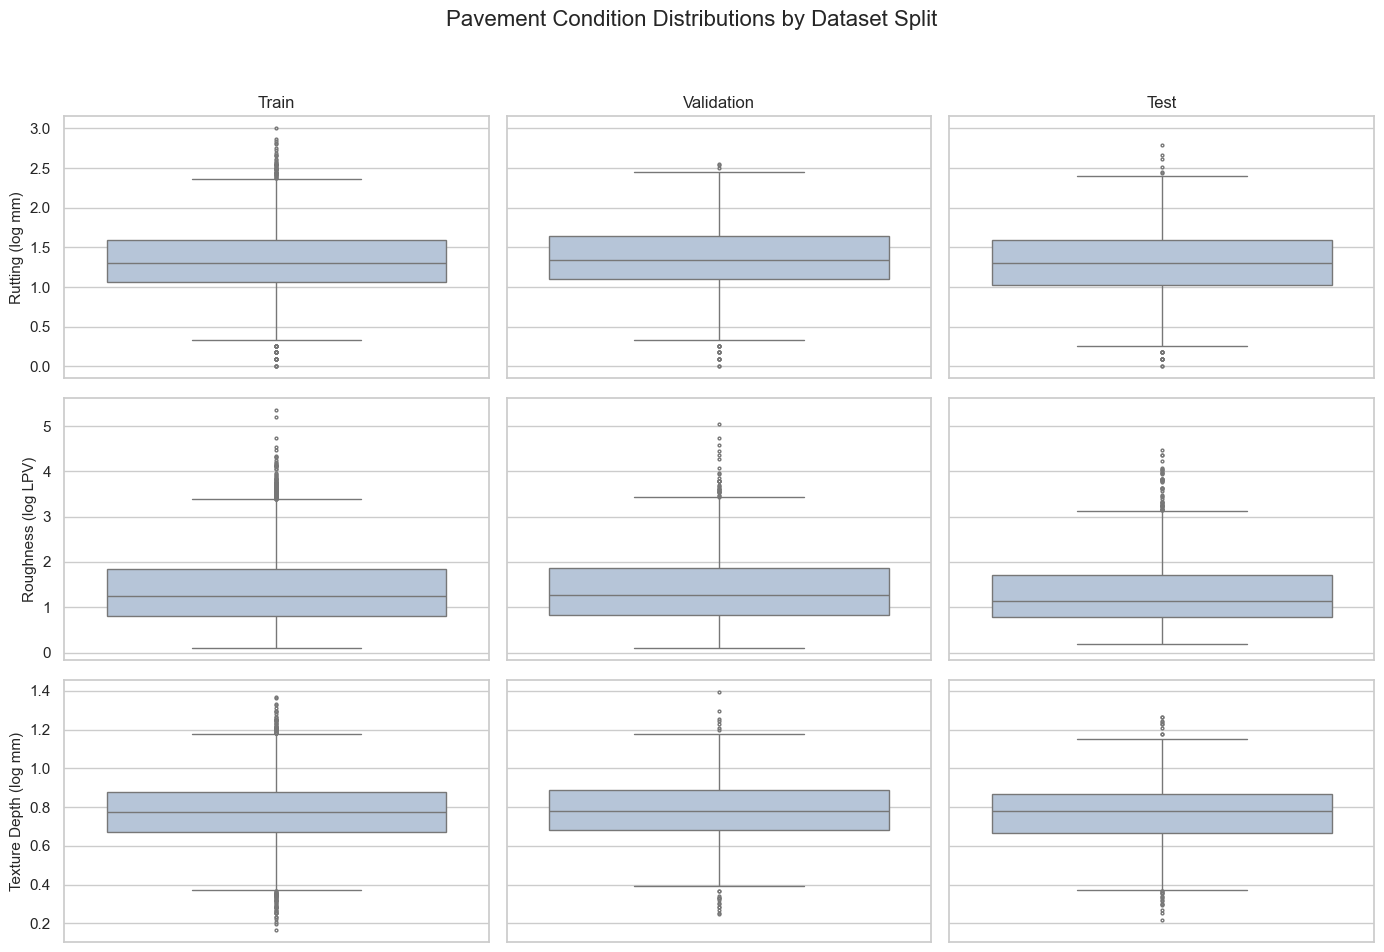

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_condition_distributions_rotated(df_train, df_validate, df_test):
    # Plot 3x3 grid of box plots (rows = condition type, cols = dataset split)
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 3, figsize=(14, 10), sharey='row')

    condition_cols = {
        'llrd_log_clipped': 'Rutting (log mm)',
        'lv10_log_clipped': 'Roughness (log LPV)',
        'lltx_log_clipped': 'Texture Depth (log mm)'
    }

    datasets = {
        'Train': df_train,
        'Validation': df_validate,
        'Test': df_test
    }

    for row_idx, (col, label) in enumerate(condition_cols.items()):
        for col_idx, (dataset_name, df) in enumerate(datasets.items()):
            ax = axes[row_idx, col_idx]
            sns.boxplot(y=df[col], ax=ax, color='lightsteelblue', fliersize=2)

            if row_idx == 0:
                ax.set_title(dataset_name, fontsize=12)
            if col_idx == 0:
                ax.set_ylabel(label, fontsize=11)
            else:
                ax.set_ylabel('')
            ax.set_xlabel('')
            ax.grid(True, axis='y')

    fig.suptitle("Pavement Condition Distributions by Dataset Split", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_condition_distributions_rotated(df_train, df_val, df_test)

Test setup and configuration
==

this runs the model with sensible (but non-optimised) defaults using the data we've described above.  Errors here mean there is a configuration problem upstream.

The results for this run are not meaningful, this is testing functionality after changes upstream.

In [ ]:

X_train = df_train[features]
X_test = df_test[features]
y_train =df_train[target]
y_test = df_test[target]

# Train model
model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    random_state=42,
    early_stopping_rounds=10,
    eval_metric = "rmse",
    enable_categorical=True
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train, 
    y_train, 
    eval_set=eval_set,
    verbose=False
)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mae_non_log_units = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
mse = mean_squared_error(y_test, y_pred)
mse_non_log_units = mean_squared_error(np.exp(y_test), np.exp(y_pred))
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
medae_non_log_units = median_absolute_error(np.exp(y_test), np.exp(y_pred))
r2 = r2_score(y_test, y_pred)


print('\n'+target+' prediction:')
print(f"MAE: {mae:.4f}")
print(f"MAE (non log units): {mae_non_log_units:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MSE: {mse_non_log_units:.4f} (non log units)")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"MedAE (non-log units): {medae_non_log_units:.4f}")
print('\n'+target)
print(df_model[target].describe())
print('\nraw data description')
print(df_sorted[target_raw].describe())


llrd_log_clipped prediction:
MAE: 0.1616
MAE (non log units): 0.6406
MSE: 0.0566
MSE: 1.1326 (non log units)
RMSE: 0.2380
R-squared: 0.6929
Median Absolute Error (MedAE): 0.1084
MedAE (non-log units): 0.4026

llrd_log_clipped
count    7653.000000
mean        1.319639
std         0.429272
min         0.000000
25%         1.064711
50%         1.308333
75%         1.589235
max         3.000720
Name: llrd_log_clipped, dtype: float64

raw data description
count    16751.000000
mean         3.144714
std          1.985267
min          0.000000
25%          1.900000
50%          2.800000
75%          4.000000
max         46.000000
Name: llrd, dtype: float64


Hyperparameter Optimisation
===

Calibrate for the actual model, using data that we have confirmed works for the approach.

In [ ]:

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2.0, 3.0]
}

X_train = df_train[features].copy()
y_train = df_train[target].copy()
groups = df_train["cluster_id"]

cv = GroupKFold(n_splits=5)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    enable_categorical=True
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,  # Try 25 combinations (adjustable)
    scoring='neg_root_mean_squared_error',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train.drop(columns=["cluster_id"]), y_train, groups=groups)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200, ...], ...}"
,n_iter,25
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
print("Best parameters found:")
print(random_search.best_params_)
print(f"Best RMSE (CV): {-random_search.best_score_:.4f}")

Best parameters found:
{'subsample': 0.6, 'reg_lambda': 3.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best RMSE (CV): 0.2186


Validation training
---

In [ ]:
best_model = random_search.best_estimator_

X_validate = df_val[features].copy().drop(columns=["cluster_id"])
y_validate = df_val[target]

y_pred = best_model.predict(X_validate)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

mae = mean_absolute_error(y_validate, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate, y_pred)
medae = median_absolute_error(y_validate, y_pred)

print(f"\nValidation Performance ("+target+"):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f} ")
print(f"R2: {r2:.4f}")
print(f"MedAE: {medae:.4f}")


Validation Performance (llrd_log_clipped):
RMSE: 0.2380
MAE: 0.1460 
R2: 0.7675
MedAE: 0.0997


Train and Assess the final model 
--

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import numpy as np


# Assign training and test data
X_train = df_train[features].copy().drop(columns=["cluster_id"])
y_train = df_train[target]
X_test = df_test[features].copy().drop(columns=["cluster_id"])
y_test = df_test[target]

# Optional: Use validation set if needed
X_val = df_val[features]
y_val = df_val[target]

best_params = random_search.best_params_.copy()

# Train with best params
model = XGBRegressor(
    **best_params,
    random_state=42,
    early_stopping_rounds=10,
    eval_metric="rmse",
    enable_categorical=True
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Predict and evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mae_non_log_units = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
mse = mean_squared_error(y_test, y_pred)
mse_non_log_units = mean_squared_error(np.exp(y_test), np.exp(y_pred))
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
medae_non_log_units = median_absolute_error(np.exp(y_test), np.exp(y_pred))
r2 = r2_score(y_test, y_pred)


print('\n'+target+' prediction:')
print(f"MAE: {mae:.4f}")
print(f"MAE (non log units): {mae_non_log_units:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MSE: {mse_non_log_units:.4f} (non log units)")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"MedAE (non-log units): {medae_non_log_units:.4f}")
print('\n'+target)
print(df_model[target].describe())
print('\nraw data description')
print(df_sorted[target_raw].describe())


llrd_log_clipped prediction:
MAE: 0.1577
MAE (non log units): 0.6269
MSE: 0.0529
MSE: 1.0637 (non log units)
RMSE: 0.2300
R-squared: 0.7133
Median Absolute Error (MedAE): 0.1086
MedAE (non-log units): 0.4033

llrd_log_clipped
count    7653.000000
mean        1.319639
std         0.429272
min         0.000000
25%         1.064711
50%         1.308333
75%         1.589235
max         3.000720
Name: llrd_log_clipped, dtype: float64

raw data description
count    16751.000000
mean         3.144714
std          1.985267
min          0.000000
25%          1.900000
50%          2.800000
75%          4.000000
max         46.000000
Name: llrd, dtype: float64


Overfitting check:
--
Confirm that we're not overfitting by comparing the results of the trained model to the results of the validation model


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
y_train_pred = model.predict(X_train)

print(f"\n{target} overfitting:")
print('=========')
print('Overfit checking')
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R² :", r2_score(y_test, y_pred))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE :", mean_absolute_error(y_test, y_pred))


llrd_log_clipped overfitting:
Overfit checking
Train R²: 0.7940991089156036
Test R² : 0.7133271810544821
Train MAE: 0.14030146199323248
Test MAE : 0.15767804817748943


In [ ]:
X_train.head()

,aadf,hgv_aadf,lcrv_clipped,lfal_clipped,lgrd,speed_limit,number_of_lanes,sqrt_mdj,geotech,llrd_log_lag1,delta_days,llrd_log_lag2,delta_days_lag
6251,14850.0,920.0,-0.380653,-0.104637,2.1,50,1,40.546270,1,1.589235,686.0,1.252763,389.0
5760,14850.0,920.0,0.237753,-0.193664,-0.3,50,1,32.093613,6,1.686399,732.0,1.193922,708.0
5789,14850.0,920.0,0.237753,0.162445,0.4,50,1,32.093613,6,1.931521,693.0,1.686399,732.0
5790,14850.0,920.0,0.237753,-0.060123,-0.4,50,1,32.093613,6,1.589235,745.0,1.931521,693.0
15947,18400.0,1605.0,0.670640,1.097231,2.3,60,1,18.027756,1,0.530628,0.0,0.530628,0.0


In [ ]:
# for inclusion in the results: 
print(f"Best iteration (early stopped at): {model.best_iteration}")

Best iteration (early stopped at): 123


Linear regression bechmark:
===

Perform a linear regression on the same data to provide a comparison benchmark. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import numpy as np

# We already have:
# X_train, X_test, y_train, y_test (from previous setup)

# Train baseline linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred_lr)
mae_non_log_units = mean_absolute_error(np.exp(y_test), np.exp(y_pred_lr))
mse = mean_squared_error(y_test, y_pred_lr)
mse_non_log_units = mean_squared_error(np.exp(y_test), np.exp(y_pred_lr))
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred_lr)
medae_non_log_units = median_absolute_error(np.exp(y_test), np.exp(y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)


print('\n'+target+' prediction (Linear regression):')
print(f"MAE: {mae:.4f}")
print(f"MAE (non log units): {mae_non_log_units:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MSE: {mse_non_log_units:.4f} (non log units)")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"MedAE (non-log units): {medae_non_log_units:.4f}")
print('\n'+target)
print(df_model[target].describe())
print('\nraw data description')
print(df_sorted[target_raw].describe())



llrd_log_clipped prediction (Linear regression):
MAE: 0.2432
MAE (non log units): 0.9431
MSE: 0.1186
MSE: 2.0661 (non log units)
RMSE: 0.3444
R-squared: 0.3571
Median Absolute Error (MedAE): 0.1743
MedAE (non-log units): 0.6415

llrd_log_clipped
count    7653.000000
mean        1.319639
std         0.429272
min         0.000000
25%         1.064711
50%         1.308333
75%         1.589235
max         3.000720
Name: llrd_log_clipped, dtype: float64

raw data description
count    16751.000000
mean         3.144714
std          1.985267
min          0.000000
25%          1.900000
50%          2.800000
75%          4.000000
max         46.000000
Name: llrd, dtype: float64


Model results - Graphs and Plots. 
===

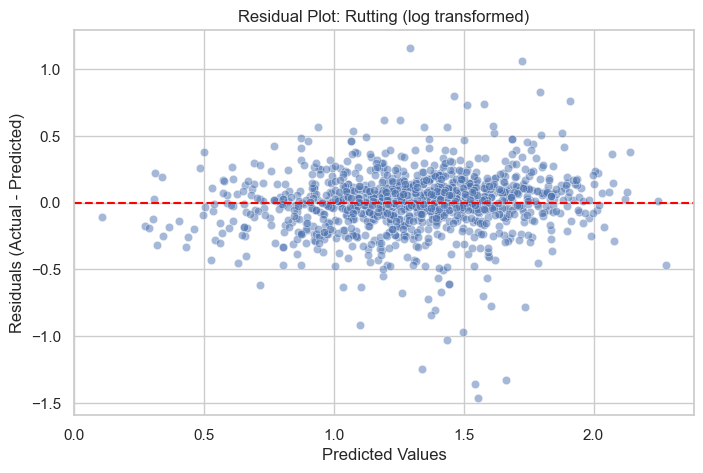

In [ ]:
# Dictionary mapping variable names to full descriptions
target_names = {
    'llrd_log_clipped': 'Rutting (log transformed)',
}

# Residual plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot: {target_names.get(target, target)}")  
plt.grid(True)
plt.show()

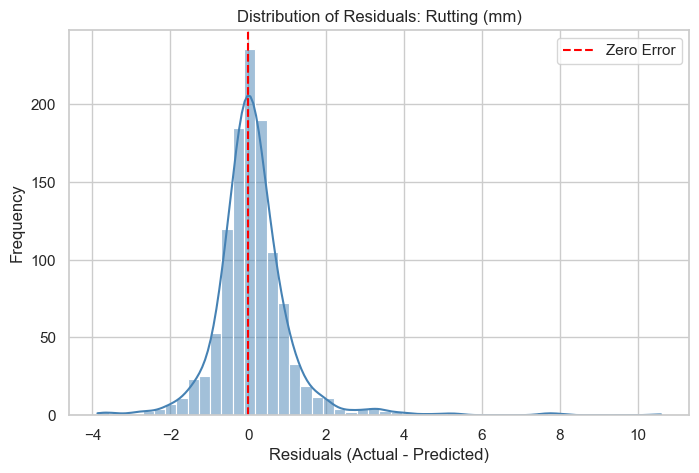

In [ ]:
# Dictionary mapping variable names to full descriptions
target_names = {
    'llrd_log_clipped': 'Rutting (mm)',
}

# Residual plot
residuals_mm = np.exp(y_test) - np.exp(y_pred) # calculating residuals in mm rather than log space. 

plt.figure(figsize=(8, 5))
sns.histplot(residuals_mm, bins=50, kde=True, color='steelblue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Residuals: {target_names.get(target, target)}")  # Uses dictionary or falls back
plt.legend()
plt.grid(True)
plt.show()

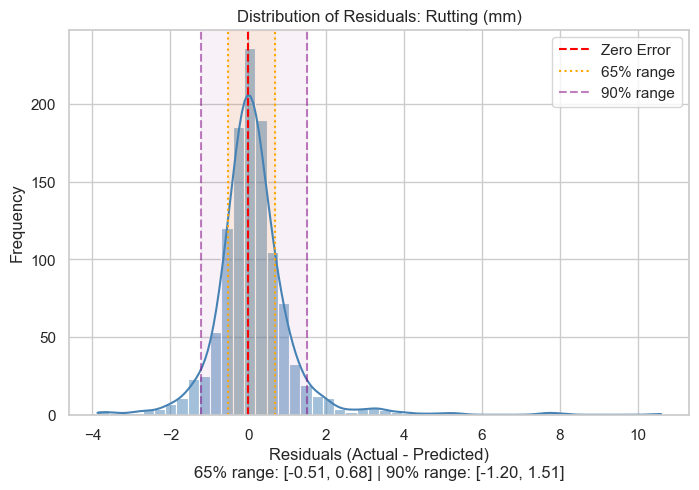

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals_mm, bins=50, kde=True, color='steelblue')

# Calculate percentile ranges (65% and 90% )
lower_90, upper_90 = np.percentile(residuals_mm, [5, 95])  # 90% range
lower_65, upper_65 = np.percentile(residuals_mm, [17.5, 82.5])  # 65% range

# Add reference lines
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.axvline(lower_65, color='orange', linestyle=':', label='65% range')
plt.axvline(upper_65, color='orange', linestyle=':')
plt.axvline(lower_90, color='purple', linestyle='--', alpha=0.5, label='90% range')
plt.axvline(upper_90, color='purple', linestyle='--', alpha=0.5)

# Add shaded regions 
plt.axvspan(lower_65, upper_65, color='orange', alpha=0.1)
plt.axvspan(lower_90, upper_90, color='purple', alpha=0.05)

plt.xlabel(f"Residuals (Actual - Predicted)\n"
           f"65% range: [{lower_65:.2f}, {upper_65:.2f}] | "
           f"90% range: [{lower_90:.2f}, {upper_90:.2f}]")
plt.ylabel("Frequency")
plt.title(f"Distribution of Residuals: {target_names.get(target, target)}")
plt.legend()
plt.grid(True)
plt.show()

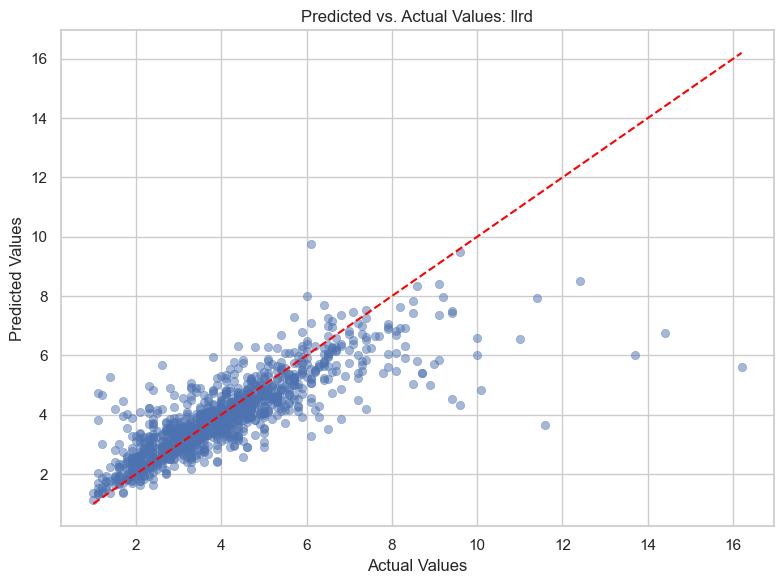

In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred), alpha=0.5, edgecolor=None)

# Plot a 45-degree reference line
min_val = min(np.exp(y_test).min(), np.exp(y_pred).min())
max_val = max(np.exp(y_test).max(), np.exp(y_pred).max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values: '+ target_raw)
plt.grid(True)
plt.tight_layout()
plt.show()

Group plot of the model diagnostics 
--

In [ ]:

def plot_diagnostics(y_test_log, y_pred_log, var_name, name_map):
    """
    Generates a 2x2 diagnostic plot grid:
    - Predicted vs Actual (log)
    - Predicted vs Actual (native)
    - Residual histogram (native)
    - Residuals vs Predicted (log)
    """
    # Convert log values back to native units
    y_test_native = np.exp(y_test_log)
    y_pred_native = np.exp(y_pred_log)

    # residuals in native space
    residuals_native = y_test_native - y_pred_native

    # Residuals in log space
    residuals_log = y_test_log - y_pred_log

    # Set up 2x2 plot
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Model Performance: {name_map.get(var_name, var_name)}', fontsize=16)

    # Plot 1: Predicted vs Actual (log scale)
    sns.scatterplot(x=y_test_log, y=y_pred_log, ax=axs[0, 0])
    axs[0, 0].plot([y_test_log.min(), y_test_log.max()],
                  [y_test_log.min(), y_test_log.max()], 'r--')
    axs[0, 0].set_title(r'$\it{a)}$  Predicted vs Actual (log units)')
    axs[0, 0].set_xlabel('Actual (log)')
    axs[0, 0].set_ylabel('Predicted (log)')
    
    # Plot 2: Predicted vs Actual (native)
    sns.scatterplot(x=y_test_native, y=y_pred_native, ax=axs[0, 1])
    axs[0, 1].plot([y_test_native.min(), y_test_native.max()],
                  [y_test_native.min(), y_test_native.max()], 'r--')
    axs[0, 1].set_title(r'$\it{b)}$  Predicted vs Actual (native units)')
    axs[0, 1].set_xlabel('Actual')
    axs[0, 1].set_ylabel('Predicted')

    # Plot 3: Residual histogram (native)
    sns.histplot(residuals_native, bins=30, kde=True, ax=axs[1, 0])
    axs[1, 0].set_title(r'$\it{c)}$  Histogram of Residuals (native units)')
    axs[1, 0].set_xlabel('Residual')

    # Plot 4: Residuals vs Predicted (log)
    sns.scatterplot(x=y_pred_log, y=residuals_log, ax=axs[1, 1])
    axs[1, 1].axhline(0, color='red', linestyle='--')
    axs[1, 1].set_title(r'$\it{d)}$  Residuals vs Predicted (log units)')
    axs[1, 1].set_xlabel('Predicted (log)')
    axs[1, 1].set_ylabel('Residual (log)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

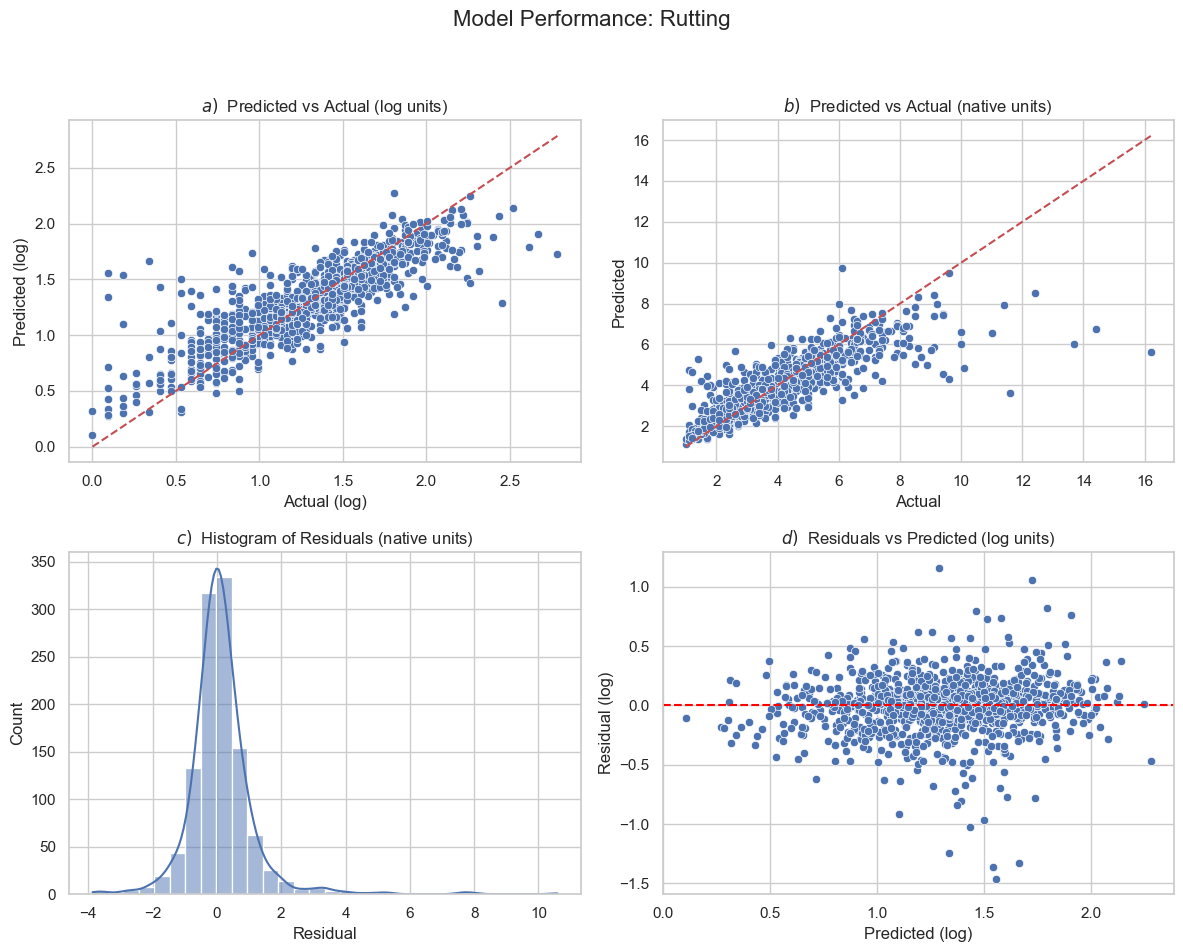

In [ ]:
name_map = {
    'llrd': 'Rutting',
    'lltx': 'Texture Depth',
    'lv10': 'Roughness (LPV)'
}

plot_diagnostics(y_test, y_pred, var_name='llrd', name_map=name_map)

In [ ]:
tolerance = 1.5
within_tolerance = (residuals_mm.abs() <= tolerance).sum()
total = len(residuals_mm)
percent = (within_tolerance / total) * 100
print (round(percent, 2),' within ',tolerance)

91.96  within  1.5


Error calculation
--

Calculate the error bounds from our forecast. 

In [ ]:
# calculate the proportion of our data within a particular confidence interval. 

from statsmodels.stats.proportion import proportion_confint

def proportion_within_ci(residuals, tolerance, alpha=0.05):
    # residuals within confidence interval. Should be in native units for clarity (but should work with log units). 
    n = len(residuals)
    within = (np.abs(residuals) <= tolerance)
    count = within.sum()
    pct = 100 * count / n
    ci_low, ci_high = proportion_confint(count, n, alpha=alpha, method='wilson')
    return pct, 100 * ci_low, 100 * ci_high

# Residuals within 3 mm
pct, ci_lo, ci_hi = proportion_within_ci(residuals_mm, tolerance=1.5)
print(f"{pct:.2f}% of residuals within ±{tolerance}mm (95% CI: {ci_lo:.2f}% – {ci_hi:.2f}%)")

91.96% of residuals within ±1.5mm (95% CI: 90.24% – 93.40%)


Key metrics for the distribution of the residuals:
---

In [ ]:

residuals = residuals_mm.copy()

# Summary statistics
mean_resid = residuals.mean()
std_resid = residuals.std()
min_resid = residuals.min()
max_resid = residuals.max()
skew_resid = skew(residuals)
kurt_resid = kurtosis(residuals)

# Proportion of residuals within ±0.05 mm (or another threshold)
within_005 = ((residuals.abs() <= 0.05).sum()) / len(residuals)

# Print the results
print(f"Mean Residual: {mean_resid:.4f}")
print(f"Standard Deviation: {std_resid:.4f}")
print(f"Min Residual: {min_resid:.4f}")
print(f"Max Residual: {max_resid:.4f}")
print(f"Skewness: {skew_resid:.4f}")
print(f"Kurtosis: {kurt_resid:.4f}")
print(f"Proportion of residuals within ±0.05 mm: {within_005:.2%}")

Mean Residual: 0.1239
Standard Deviation: 1.0243
Min Residual: -3.8688
Max Residual: 10.5902
Skewness: 2.4927
Kurtosis: 19.7719
Proportion of residuals within ±0.05 mm: 7.87%


Calculation of Error using Observed Distribution of Residuals
---

In [ ]:

# 1. Compute residuals in log space. 
# Becuase the training data and target variable were in log space, this is appropriate here. 

res_log = y_test - y_pred # for clarity, y_test is the test set, y_pred are the mode outputs. 

lower_q = res_log.quantile(0.025) #0.025 and 0.975 to catch 95% of the population. 
upper_q = res_log.quantile(0.975)

lower_factor_95 = np.exp(lower_q)
upper_factor_95 = np.exp(upper_q)

# Apply to the predicted values
y_pred_mm = np.exp(y_pred)
lower_bound_95 = y_pred_mm * lower_factor_95
upper_bound_95 = y_pred_mm * upper_factor_95

# for 65 confidence. 

lower_q_65 = res_log.quantile(0.175)
upper_q_65 = res_log.quantile(0.825)

lower_factor_65 = np.exp(lower_q_65)
upper_factor_65 = np.exp(upper_q_65)

# Apply these to the predicted values
y_pred_mm = np.exp(y_pred)
lower_bound_65 = y_pred_mm * lower_factor_65
upper_bound_65 = y_pred_mm * upper_factor_65

print('upper factor (95): ', round(upper_factor_95, 2), 'lower factor (95): ', round(lower_factor_95, 2) )
print('upper factor (65): ', round(upper_factor_65, 2), 'lower factor (65): ', round(lower_factor_65, 2) )

confidence_bounds_df = pd.DataFrame (
    data = {'test':y_test, 
            'pred':y_pred, 
            'test_mm':np.exp(y_test), 
            'pred_mm':np.exp(y_pred),  
            'lower_bound_95': lower_bound_95, 
            'upper_bound_95':upper_bound_95,
            'lower_bound_65': lower_bound_65, 
            'upper_bound_65':upper_bound_65,           
           } )

confidence_bounds_df.head()


upper factor (95):  1.52 lower factor (95):  0.62
upper factor (65):  1.17 lower factor (65):  0.84


,test,pred,test_mm,pred_mm,lower_bound_95,upper_bound_95,lower_bound_65,upper_bound_65
16277,0.955511,0.987135,2.6,2.683536,1.668878,4.082533,2.264577,3.136369
16621,1.098612,1.072271,3.0,2.922009,1.817183,4.445329,2.465819,3.415083
10933,1.871802,1.847186,6.5,6.341951,3.944028,9.648176,5.351832,7.412124
10934,1.568616,1.596389,4.8,4.935178,3.069163,7.508016,4.164688,5.767965
10935,1.840550,1.727057,6.3,5.624077,3.497586,8.556056,4.746034,6.573113


In [ ]:
print('upper factor (95): ', round(upper_factor_95, 2), 'lower factor (95): ', round(lower_factor_95, 2) )
print('upper factor (65): ', round(upper_factor_65, 2), 'lower factor (65): ', round(lower_factor_65, 2) )

upper factor (95):  1.52 lower factor (95):  0.62
upper factor (65):  1.17 lower factor (65):  0.84


Parametric Error:
---

Calculate the error assuming a normal distribution for the residuals. They're close, but not quite, normally distributed, making this an interesting baseline comparison. 

In [ ]:
import numpy as np
from scipy.stats import norm

# Parametric approach assuming normal residuals - checking methodology. 

res_log = y_test - y_pred

residual_std = np.std(res_log)  # calculate standard deviation of log residuals. 

# Use quantiles from the normal distribution instead of measured values:
z = norm.ppf(0.975)  
print(z) # 1.959963984540054 @ 95%

lower_q = -z * residual_std
upper_q = z * residual_std
print(lower_q, upper_q)

lower_factor_95 = np.exp(lower_q)
upper_factor_95 = np.exp(upper_q)

z = norm.ppf(0.825)
print(z)
lower_q = -z * residual_std
upper_q = z * residual_std

lower_factor_65 = np.exp(lower_q)
upper_factor_65 = np.exp(upper_q)


print(f"Parametric 95% CI factors: [{lower_factor_95:.2f}, {upper_factor_95:.2f}]")
print(f"Parametric 65% CI factors: [{lower_factor_65:.2f}, {upper_factor_65:.2f}]")

1.959963984540054
-0.4506605946038922 0.4506605946038922
0.9345892910734801
Parametric 95% CI factors: [0.64, 1.57]
Parametric 65% CI factors: [0.81, 1.24]


Feature Importance Analysis
---

Feature importance for the model using SHAP.

In [ ]:
import shap
import matplotlib.pyplot as plt

name_map = {
"aadf" : 'AADF',
"hgv_aadf" : 'HGV AADF',
"lcrv_clipped": 'Curvature',       
"lfal_clipped": 'Crossfall',       
"lgrd": 'Gradient',                    
"speed_limit": 'Speed Limit',          
"number_of_lanes": 'Number of lanes',      
"sqrt_mdj": 'Distance to Junction',          
"geotech": 'Geotechnical Context',              
"llrd_log_lag1": "Historic Rutting 1",      
"lv10_log_lag1": "Historic Roughness 1",      
"lltx_log_lag1": "Historic Texture Depth 1",      
"delta_days": "Time Delta 1",         
"llrd_log_lag2": "Historic Rutting 2",
"lv10_log_lag2": "Historic Roughness 2",    
"lltx_log_lag2": "Historic  Texture 2",     
"delta_days_lag": "Time Delta 2"       
}

test_renamed = X_test.copy()
test_renamed.columns = [name_map.get(col, col) for col in X_test.columns]

train_renamed = X_train.copy()
train_renamed.columns = [name_map.get(col, col) for col in X_test.columns]


# Use TreeExplainer for XGBoost models
explainer = shap.Explainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(test_renamed)

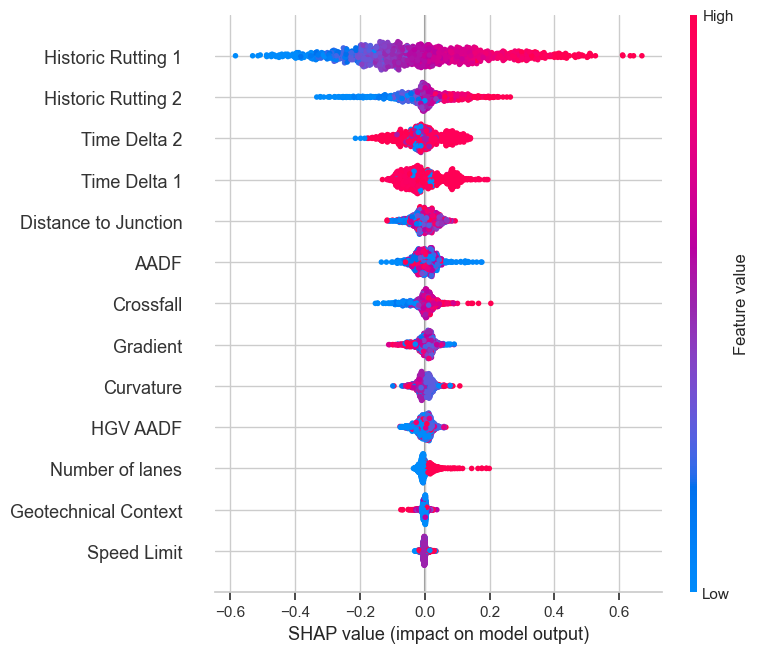

In [ ]:
shap.summary_plot(shap_values, test_renamed, plot_type="dot", show=True)

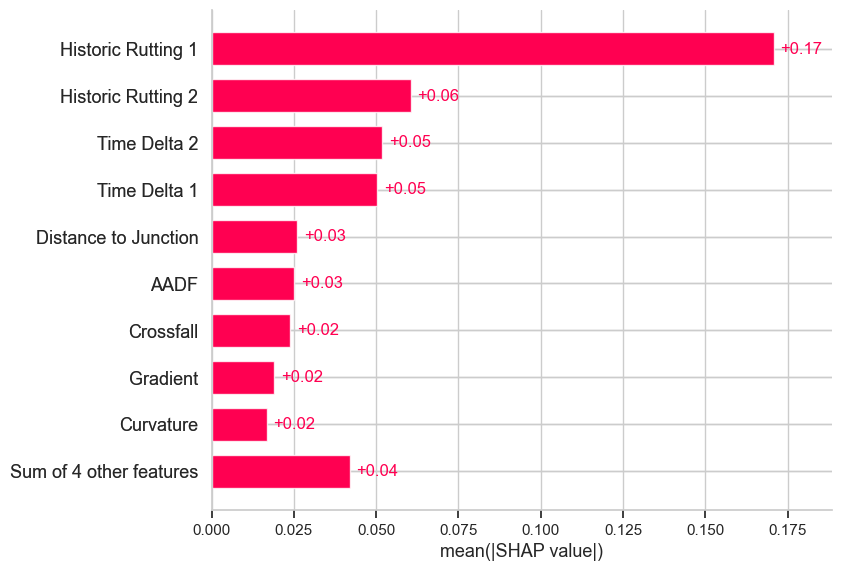

In [ ]:
shap.plots.bar(shap_values, max_display=10)

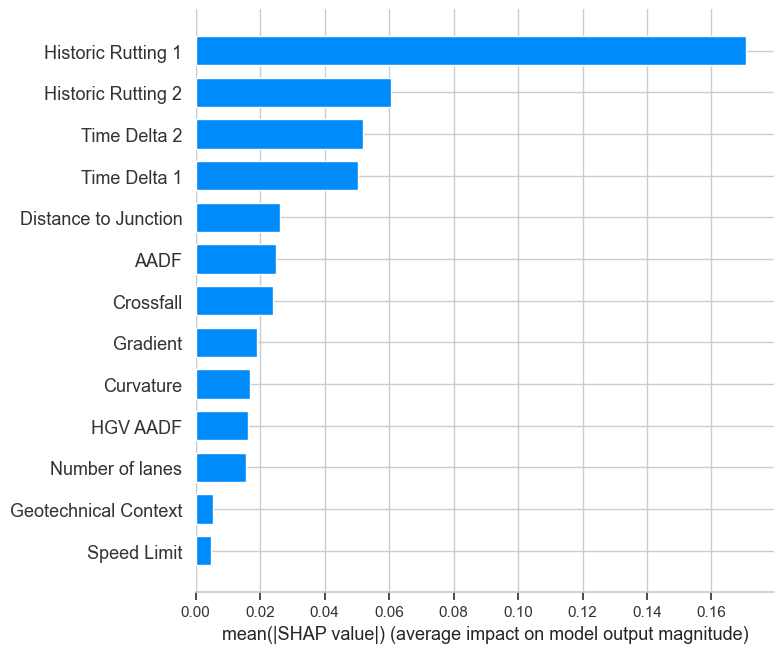

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

Feature Specific Shap values (Example)
---

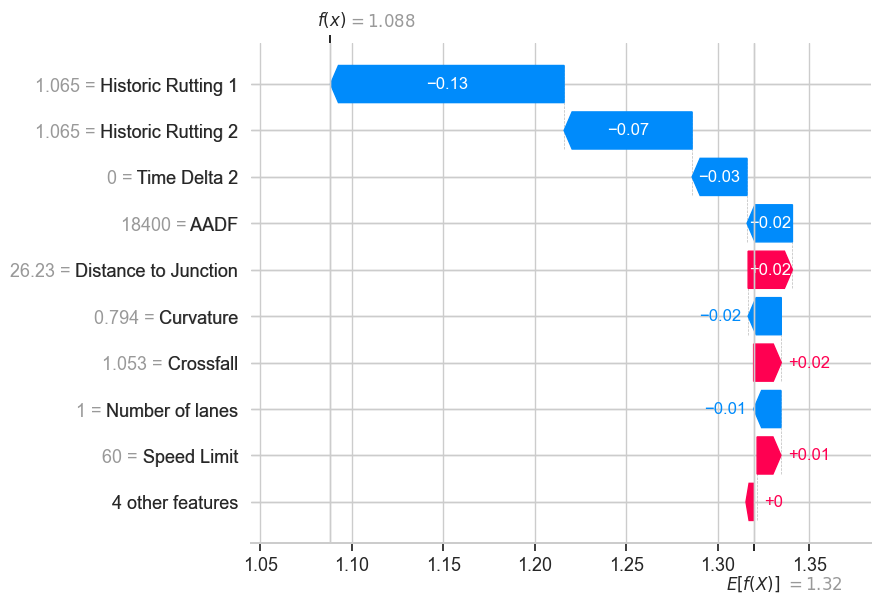

In [ ]:
i = 798
shap.plots.waterfall(shap_values[i])

In [ ]:
X_test.head()

,aadf,hgv_aadf,lcrv_clipped,lfal_clipped,lgrd,speed_limit,number_of_lanes,sqrt_mdj,geotech,llrd_log_lag1,delta_days,llrd_log_lag2,delta_days_lag
16277,18400.0,1605.0,0.608797,1.230772,-2.9,60,1,21.863211,1,0.955511,0.0,0.955511,0.0
16621,20250.0,1480.0,-0.380653,0.607581,2.8,60,1,26.832816,8,0.336472,732.0,1.064711,708.0
10933,7825.0,980.0,-1.060899,-1.529073,1.3,50,2,21.679483,1,0.993252,389.0,1.960095,2421.0
10934,7825.0,980.0,-1.060899,-1.573586,2.1,50,2,21.679483,1,1.871802,686.0,0.993252,389.0
10935,7825.0,980.0,-1.184572,-1.217477,1.6,50,2,21.679483,1,1.568616,717.0,1.871802,686.0


Wide layout feature importance, for inclusion in the report. 


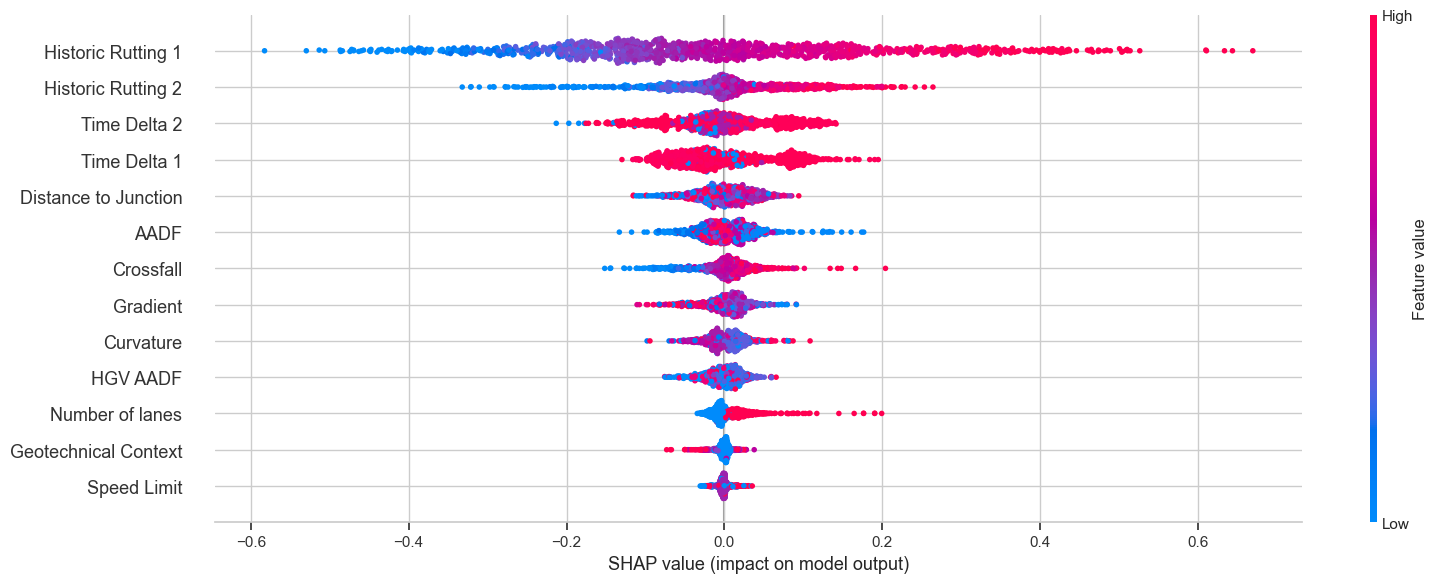

In [ ]:
import shap
import matplotlib.pyplot as plt

# Make sure you have the SHAP values and renamed test set
# shap_values = explainer(X_test)
# X_test_renamed = ...

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
shap.summary_plot(shap_values, test_renamed, plot_type='bar', show=False, plot_size=None)
axs[0].imshow(plt.gcf().canvas.buffer_rgba())  # copy image to subplot
axs[0].axis('off')
axs[0].set_title('SHAP Feature Importance (Bar)')

plt.clf()  # Clear the previous plot so the next one doesn’t overlay

# Beehive plot
shap.summary_plot(shap_values, test_renamed, show=False, plot_size=None)
axs[1].imshow(plt.gcf().canvas.buffer_rgba())
axs[1].axis('off')
axs[1].set_title('SHAP Feature Impact (Beehive)')

plt.tight_layout()
plt.show()